# Phishing detection

## Dataset

### Loading the data


In [70]:
import pandas as pd

# Load the kaggle dataset
data = pd.read_csv("dataset_phishing.csv")

# Prints the first few rows
print(data.head())

# Displays dataset information
print(data.info())


                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                


### Editing the data
The Status column (#88) is the one saying whether it´s phishing or if the url is legitimate, for purposes of training the model the column is being changed to:
- 0 = legitimate
- 1 = phishing

In [71]:
data['status'] = data['status'].replace({'legitimate': 0, 'phishing': 1})

print(data.head())

data = data.drop(columns=['url'])      #Dropping this column since it isn´t a numerical one helpful for the model  
# Separates the independent variable (x) from the dependent variable column (y)
x = data.drop(columns=['status'])  
y = data['status'] 

print(data.info())


                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                

### Spliting the data
The data is being split in 3 parts, 80% train & validation and 20% test. Further, the first part will be divided in 70% train and 30% validation.

The total dataset has 11,430 rows.

In [72]:
from sklearn.model_selection import train_test_split

xTrainVal, xTest, yTrainVal, yTest = train_test_split(x, y, test_size=0.2, random_state=453890, stratify=y)

# Splits the train+validation data into train (70%) and validation (30%)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainVal, yTrainVal, test_size=0.3, random_state=453890, stratify=yTrainVal
)

print(f"Train set: {len(xTrain)} rows")
print(f"Validation set: {len(xVal)} rows")
print(f"Test set: {len(xTest)} rows\n")

print("Values distribution:")
print(f"Train:\n{yTrain.value_counts(normalize=True)}\n")
print(f"Validation:\n{yVal.value_counts(normalize=True)}\n")
print(f"Test:\n{yTest.value_counts(normalize=True)}\n")

Train set: 6400 rows
Validation set: 2744 rows
Test set: 2286 rows

Values distribution:
Train:
0    0.5
1    0.5
Name: status, dtype: float64

Validation:
0    0.5
1    0.5
Name: status, dtype: float64

Test:
0    0.5
1    0.5
Name: status, dtype: float64



# Training the model

In [82]:
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=453890    # For reproducibility
)

# Train the model using the training set
rfModel.fit(xTrain, yTrain)

print("Model trained :) !")


Model trained :) !


## Validating the model

In [83]:
from sklearn.metrics import classification_report, roc_auc_score

yValPred = rfModel.predict(xVal)

# Calculates probabilities for ROC-AUC
yValProb = rfModel.predict_proba(xVal)[:, 1]

# Classification results
print("Validation Set Performance:")
print(classification_report(yVal, yValPred))

# ROC-AUC score
rocAucVal = roc_auc_score(yVal, yValProb)
print(f"Validation ROC-AUC Score: {rocAucVal}")


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1372
           1       0.96      0.97      0.97      1372

    accuracy                           0.97      2744
   macro avg       0.97      0.97      0.97      2744
weighted avg       0.97      0.97      0.97      2744

Validation ROC-AUC Score: 0.9942718913887921


## Testing the model

In [84]:
# Predict on the test set
yTestPred = rfModel.predict(xTest)

# Calculate probabilities for ROC-AUC
yTestProb = rfModel.predict_proba(xTest)[:, 1]

# Classification report
print("Test set performance:")
print(classification_report(yTest, yTestPred))

# ROC-AUC score
rocAucTest = roc_auc_score(yTest, yTestProb)
print(f"Test ROC-AUC Score: {rocAucTest}")


Test set performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1143
           1       0.97      0.97      0.97      1143

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286

Test ROC-AUC Score: 0.9929782945985645


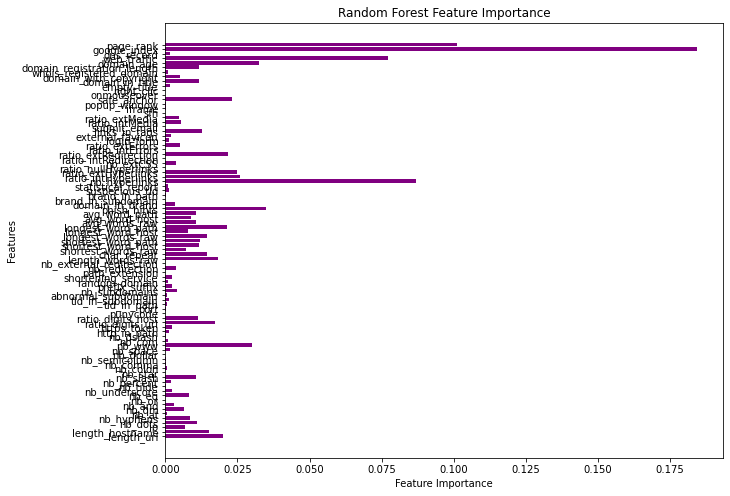

In [78]:
import matplotlib.pyplot as plt

# Get feature importances from the model
featureImportances = rfModel.feature_importances_

# Plot of the feature importances
plt.figure(figsize=(10, 8))
plt.barh(xTrain.columns, featureImportances, color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


Since there are 87 columns (86 features) the visualization of the most important ones is a bit messy, the next graph shows the top 25 relevant features. 

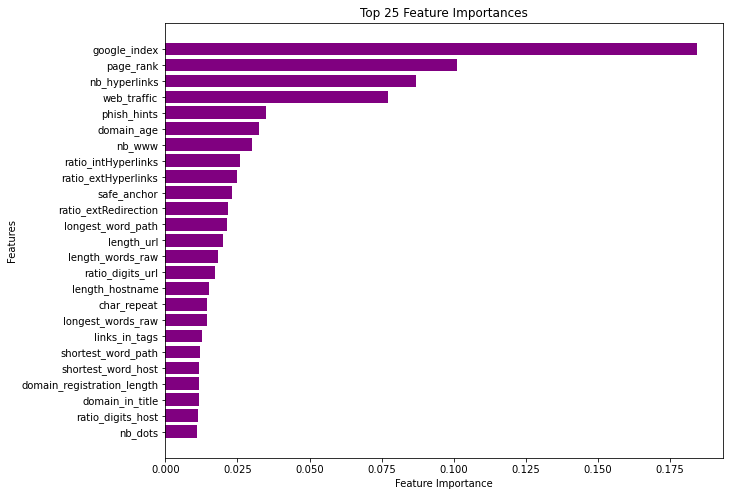

In [85]:
import numpy as np

# Sort feature importances in descending order
sortedIndices = np.argsort(featureImportances)[::-1]
topN = 25 

topFeatures = xTrain.columns[sortedIndices[:topN]]
topImportances = featureImportances[sortedIndices[:topN]]

# Plot the top N feature importances
plt.figure(figsize=(10, 8))
plt.barh(topFeatures, topImportances, color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title(f"Top {topN} Feature Importances")
plt.gca().invert_yaxis()  
plt.show()


In [86]:
import joblib

# Saves the model
joblib.dump(rfModel, "randomForestIsItPhishing1.pkl")

print("Model saved as randomForestIsItPhishing1.pkl")

Model saved as randomForestIsItPhishing1.pkl


## Finetuning the model

In [103]:
from sklearn.model_selection import GridSearchCV

paramGrid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
gridSearch = GridSearchCV(estimator=rfModel, param_grid=paramGrid, cv=3, scoring='roc_auc')
gridSearch.fit(xTrain, yTrain)

# Best parameters and model
print("Best Parameters:", gridSearch.best_params_)
optimizedModel = gridSearch.best_estimator_

# ESTA PARTE FUE LA MAS TARDADA DE CORRER (APROX. 1min16s)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [104]:
# Retrain the model with the best parameters
bestRfModel = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=453890,
)

# Train the optimized model
bestRfModel.fit(xTrain, yTrain)

print("Optimized model retrained successfully!")

Optimized model retrained successfully!


In [105]:
# Saves the model
joblib.dump(bestRfModel, "randomForestIsItPhishing2.pkl")

print("Model saved as randomForestIsItPhishing2.pkl")

Model saved as randomForestIsItPhishing2.pkl


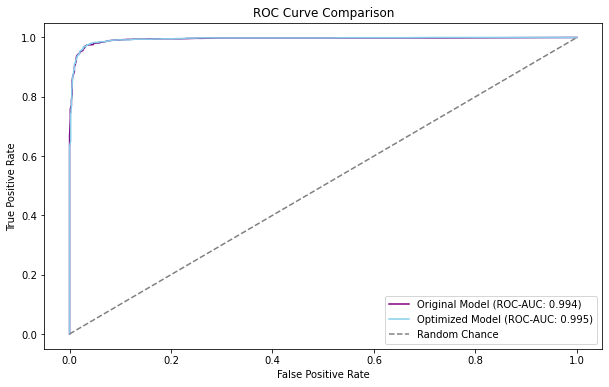

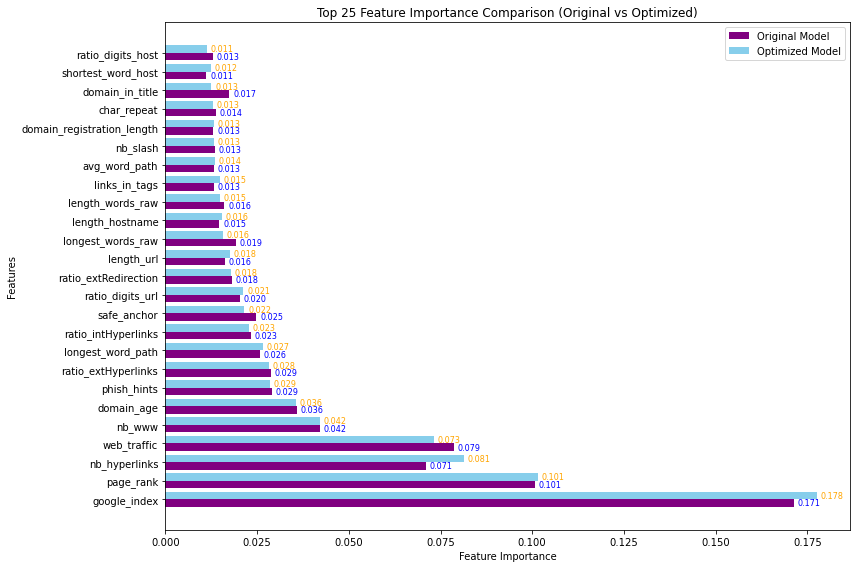

In [106]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curves
fprOriginal, tprOriginal, _ = roc_curve(yVal, yValProbOriginal)
fprOptimized, tprOptimized, _ = roc_curve(yVal, yValProbOptimized)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fprOriginal, tprOriginal, label=f"Original Model (ROC-AUC: {rocAucValOriginal:.3f})", color="purple")
plt.plot(fprOptimized, tprOptimized, label=f"Optimized Model (ROC-AUC: {rocAucValOptimized:.3f})", color="skyblue")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Feature Importance Comparison
# Importances are already computed and normalized (not normalized here for clarity)
importancesOriginal = rfModel.feature_importances_
importancesOptimized = bestRfModel.feature_importances_

# Sort features by importance in the optimized model
sortedIndices = np.argsort(importancesOptimized)[::-1]

# Top N features to display
topN = 25
sortedIndices = sortedIndices[:topN]

# Get sorted feature names and importances
sortedFeatures = xTrain.columns[sortedIndices]
sortedOriginal = importancesOriginal[sortedIndices]
sortedOptimized = importancesOptimized[sortedIndices]

# Plot feature importance comparison
plt.figure(figsize=(12, 8))
barWidth = 0.4  # Width of the bars

# Positions for the bars
r1 = np.arange(len(sortedFeatures))
r2 = [x + barWidth for x in r1]

# Plot bars for original and optimized models
plt.barh(r1, sortedOriginal, color='purple', height=barWidth, label="Original Model")
plt.barh(r2, sortedOptimized, color='skyblue', height=barWidth, label="Optimized Model")

# Add labels to the bars
for i, (orig, opt) in enumerate(zip(sortedOriginal, sortedOptimized)):
    plt.text(orig + 0.001, i, f"{orig:.3f}", va='center', fontsize=8, color="blue")
    plt.text(opt + 0.001, i + barWidth, f"{opt:.3f}", va='center', fontsize=8, color="orange")

# Labels and title
plt.yticks([r + barWidth / 2 for r in range(len(sortedFeatures))], sortedFeatures)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 25 Feature Importance Comparison (Original vs Optimized)")
plt.legend()
plt.tight_layout()
plt.show()


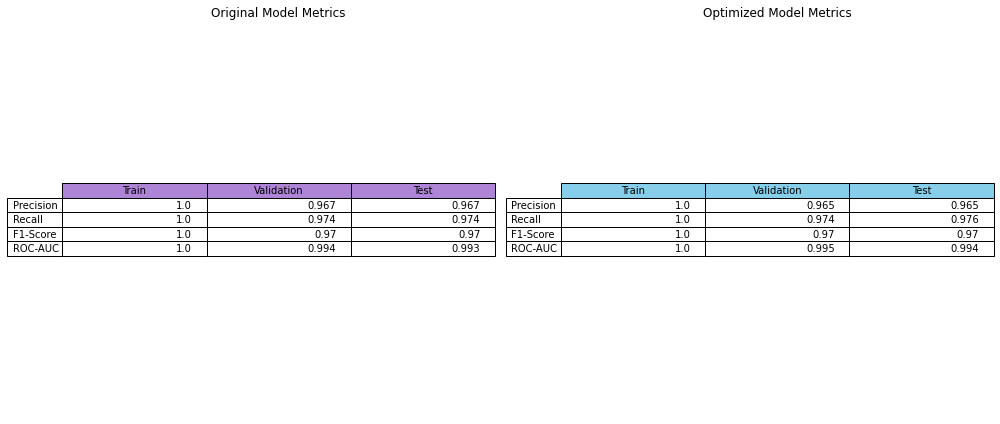

In [107]:
metrics = ["Precision", "Recall", "F1-Score", "ROC-AUC"]

originalMetrics = {
    "Train": [precisionTrainOriginal, recallTrainOriginal, f1TrainOriginal, rocAucTrainOriginal],
    "Validation": [precisionValOriginal, recallValOriginal, f1ValOriginal, rocAucValOriginal],
    "Test": [precisionTestOriginal, recallTestOriginal, f1TestOriginal, rocAucTestOriginal]
}

optimizedMetrics = {
    "Train": [precisionTrainOptimized, recallTrainOptimized, f1TrainOptimized, rocAucTrainOptimized],
    "Validation": [precisionValOptimized, recallValOptimized, f1ValOptimized, rocAucValOptimized],
    "Test": [precisionTestOptimized, recallTestOptimized, f1TestOptimized, rocAucTestOptimized]
}

originalDF = pd.DataFrame(originalMetrics, index=metrics)
optimizedDF = pd.DataFrame(optimizedMetrics, index=metrics)

# Plotting tables next to each other
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Table for Original Model
lightPurple = (0.6, 0.4, 0.8, 0.8) 

ax[0].axis("tight")
ax[0].axis("off")
ax[0].table(
    cellText=originalDF.values.round(3),  # Round to 3 decimal places for clarity
    colLabels=originalDF.columns,
    rowLabels=originalDF.index,
    loc="center",
    colColours=[lightPurple] * 3,  # Use light blue for columns
)
ax[0].set_title("Original Model Metrics")

# Table for Optimized Model
ax[1].axis("tight")
ax[1].axis("off")
ax[1].table(
    cellText=optimizedDF.values.round(3),  # Round to 3 decimal places for clarity
    colLabels=optimizedDF.columns,
    rowLabels=optimizedDF.index,
    loc="center",
    colColours=["skyblue"] * 3,  # Use light green for columns
)
ax[1].set_title("Optimized Model Metrics")

# Adjust layout and display
plt.tight_layout()
plt.show()
